In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [201]:
def import_24bit_data(fn):
    table = pd.read_csv(fn, sep=',', skiprows = 0)
    table.columns = np.arange(0,422,1)
    
    data_ch0 = []
    for i in range(len(table[0])):
        for j in range(60):
            data_ch0.append(table[j][i])
            
    data_ch1 = []
    for i in range(len(table[60])):
        for j in range(60):
            data_ch1.append(table[60 + j][i])
            
    data_ch2 = []
    for i in range(len(table[120])):
        for j in range(60):
            data_ch2.append(table[120 +j][i])
            
    clock_ticks = []
    for i in range(len(table[360])):
        for j in range(60):
            clock_ticks.append(table[360+j][i])
    
    data_ch0 = np.array(data_ch0)
    data_ch1 = np.array(data_ch1)
    data_ch2 = np.array(data_ch2)
    clock_ticks = np.array(clock_ticks)
    times_1 = np.array(table[420])
    times_2 = np.array(table[421])

    clock_float = clock_ticks.astype(float)

    clock_ticks_diff = []
    for i in range(len(clock_ticks) - 1):
        diff = clock_float[i+1] - clock_float[i]
        if diff > 0:
            clock_ticks_diff.append(diff)

    clock_rate = 10**6
    
    #clock_ticks_diff = [clock_float[i+1] - clock_float[i] for i in range(len(clock_ticks)-1)]
    print("NUMBER OF DATA POINTS:", len(data_ch1))
    print("MEAN CLOCK TICK DIFF:", np.mean(clock_ticks_diff))
    print("MEAN PERIOD:", np.mean(clock_ticks_diff)/(clock_rate))
    print("MEAN FREQ (Hz):", 1/(np.mean(clock_ticks_diff)/(clock_rate)))
        
    return data_ch0, data_ch1, data_ch2, clock_ticks, times_1, times_2, 1/(np.mean(clock_ticks_diff)/clock_rate)

In [202]:
fn = r"C:\Users\natal\Accelerometer_data\20250714T122531_cgem_accel\20250714T122531_FILE0001_cgem_accel.csv" #replace file path
data_ch0, data_ch1, data_ch2, clock_ticks, times1, times2, mean_freq = import_24bit_data(fn)

NUMBER OF DATA POINTS: 15540
MEAN CLOCK TICK DIFF: 1224.4266958424507
MEAN PERIOD: 0.0012244266958424507
MEAN FREQ (Hz): 816.7087530805289


In [203]:
voltage = lambda raw: 2.5*(raw / (16777215))

def accel(raw_ch):
    v = voltage(raw_ch)
    a = (v - 0.9) / 0.2
    return a

In [204]:
print("Voltage (V):")
print("channel 0 average voltage:", voltage(np.mean(data_ch0)))
print("channel 1 average voltage:", voltage(np.mean(data_ch1)))
print("channel 2 average voltage:", voltage(np.mean(data_ch2)))
print("")
print("Acceleration (g):")
print("channel 0 average accel:", accel(np.mean(data_ch0)))
print("channel 1 average accel:", accel(np.mean(data_ch1)))
print("channel 2 average accel:", accel(np.mean(data_ch2)))

Voltage (V):
channel 0 average voltage: 0.8235412934373847
channel 1 average voltage: 0.9407990500523364
channel 2 average voltage: 1.0724335364167645

Acceleration (g):
channel 0 average accel: -0.38229353281307665
channel 1 average accel: 0.20399525026168208
channel 2 average accel: 0.8621676820838226


C:\Users\natal\AppData\Local\Temp\ipykernel_16964\2026198121.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


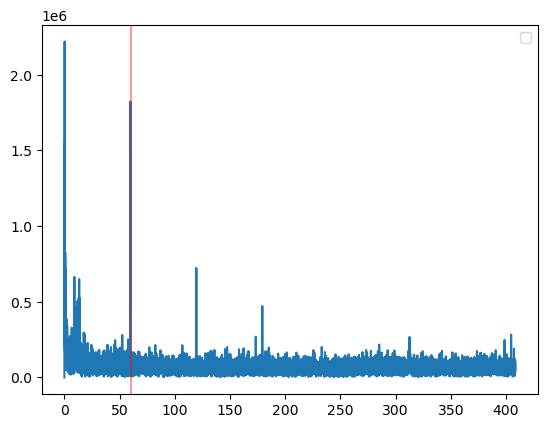

In [205]:
data_ch = data_ch1 #set to any data channel
sampling_rate = 817
s = np.fft.fft(data_ch - data_ch.mean()) 
freqs = np.fft.fftfreq(len(data_ch), d=1/sampling_rate)

positive_freqs = freqs[:len(data_ch) // 2]
positive_magnitude = np.abs(s[:len(data_ch) // 2])

# Plot frequencies
plt.plot(positive_freqs, positive_magnitude)
plt.legend()

plt.axvline(60, c='red', label='60Hz', alpha=0.4)
plt.show()

In [206]:
def shuyu_fft(data, bin_size, freq):
    """
    data = data
    bin_size = integer number of data points to bin and FFT together
    freq = sampling freq
    """
    
    num_bins = int(len(data)/bin_size)
        
    fft_average = np.zeros(bin_size // 2)
    fft_ = np.zeros((num_bins, bin_size // 2))
    
    fft_freq = np.fft.fftfreq(bin_size, d=1/freq)[:bin_size // 2]
    
    for i in range(num_bins):
        data_bin = data[i*bin_size : (i + 1)*bin_size]
        
        fft_bin = np.fft.fft(data_bin)[:bin_size // 2]
        
        fft_[i] = (2 / bin_size) * np.abs(fft_bin)
        
        fft_average += fft_[i]
    
    fft_average = fft_average / num_bins
    
    return fft_, fft_average, fft_freq, num_bins 

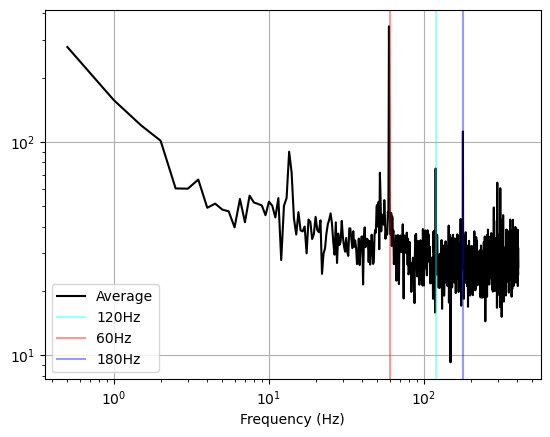

347.9161392807746


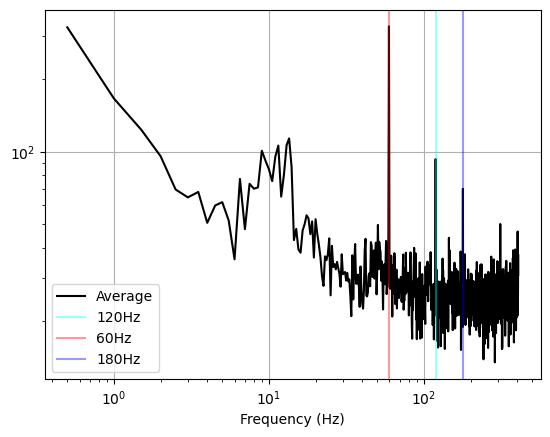

328.80470078290693


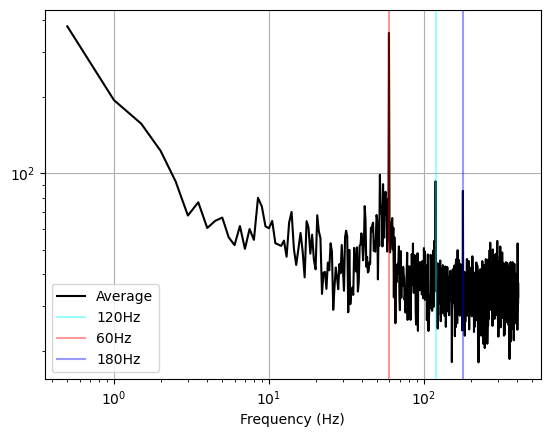

378.83288662400105


In [207]:
for data_ch in data_ch0, data_ch1, data_ch2:
    fft_ch, fft_average_ch, fft_freq_ch, num_bins_ch = shuyu_fft(data_ch, int(813.35*2), 813.35)
    valid_indices = fft_freq_ch > 0
    plt.plot(fft_freq_ch[valid_indices], abs(fft_average_ch[valid_indices]), color='black', label='Average')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    #plt.xlim(98,100)
    plt.axvline(120, c='cyan', label='120Hz', alpha=0.4)
    plt.axvline(60, c='red', label='60Hz', alpha=0.4)
    plt.axvline(180, c='blue', label='180Hz', alpha=0.4)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print(max(abs(fft_average_ch[valid_indices])))

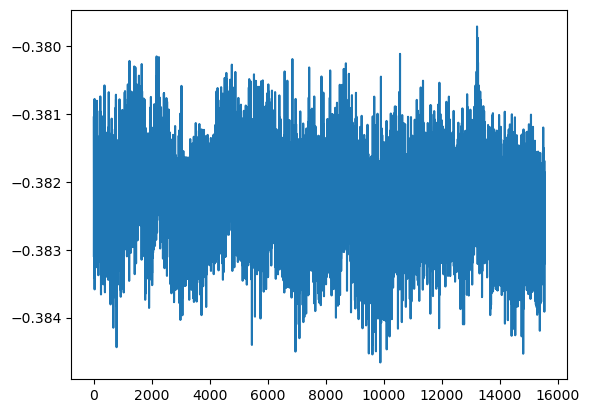

In [208]:
plt.plot(accel(data_ch0))

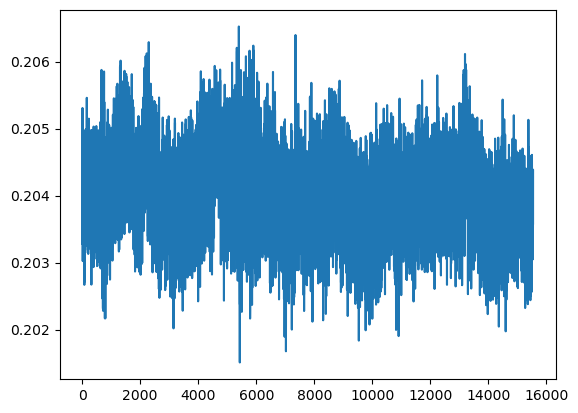

In [209]:
plt.plot(accel(data_ch1))

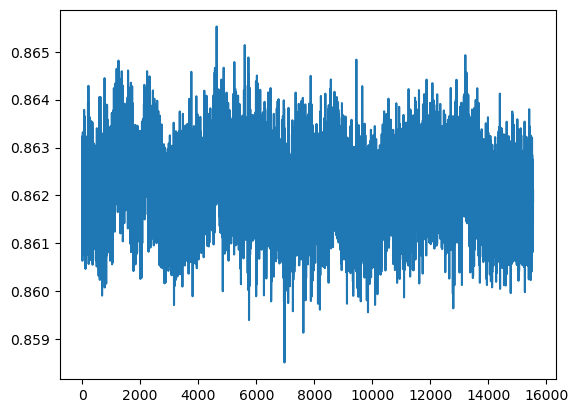

In [210]:
plt.plot(accel(data_ch2))